In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [2]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [3]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Temperature/Rajshahi.csv')
#the daily dataset
print(df.shape)
df.head()

(600, 4)


,DATE,Max Temp,Min Temp,MEAN
0,1/31/1964,30.7,10.8,20.75
1,2/29/1964,34.4,13.5,23.95
2,3/31/1964,37.2,18.4,27.80
3,4/30/1964,37.5,23.4,30.45
4,5/31/1964,37.7,24.3,31.00


In [4]:
#checking types
df.pop('Max Temp')
df.pop('Min Temp')
df.dtypes

DATE     object
MEAN    float64
dtype: object

Data Preprocessing
---------

In [5]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

           DATE   MEAN
0     1/31/1964  20.75
1     2/29/1964  23.95
2     3/31/1964  27.80
3     4/30/1964  30.45
4     5/31/1964  31.00
..          ...    ...
595   8/31/2013  31.45
596   9/30/2013  32.10
597  10/31/2013  29.10
598  11/30/2013  24.10
599  12/31/2013  21.00

[600 rows x 2 columns]


In [6]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [7]:
df.head()

,DATE,MEAN
0,1/31/1964,20.75
1,2/29/1964,23.95
2,3/31/1964,27.80
3,4/30/1964,30.45
4,5/31/1964,31.00


In [8]:
df.tail()

,DATE,MEAN
595,8/31/2013,31.45
596,9/30/2013,32.10
597,10/31/2013,29.10
598,11/30/2013,24.10
599,12/31/2013,21.00


In [9]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
#df_pr.sort_values('DATE', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('DATE', inplace=True)
df_pr.head()

,MEAN
DATE,
1/31/1964,20.75
2/29/1964,23.95
3/31/1964,27.80
4/30/1964,30.45
5/31/1964,31.00


In [10]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Rajshahi_monthly.csv")

(600, 1)


In [11]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1964-01-31 00:00:00
End Date: 2013-12-31 00:00:00
Total month: 600
Total year: 50


Data Visulalization
----------

About Data

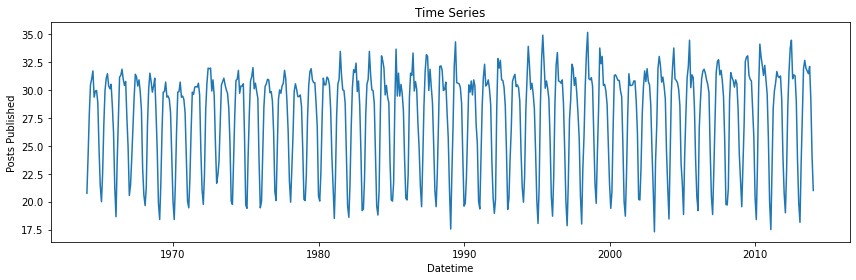

In [12]:
# 7.Plotting the time series
monthly['MEAN'] = monthly['MEAN'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(504, 1), Validation=(96, 1)


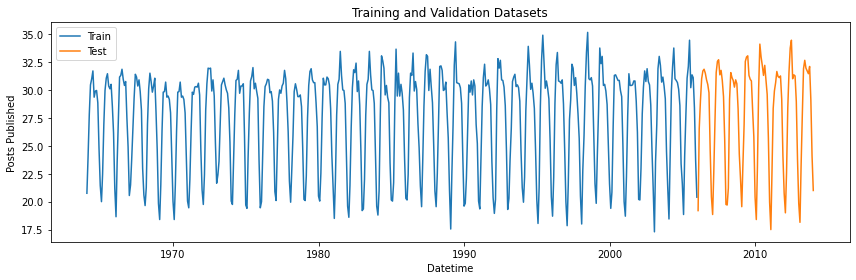

In [13]:
train = monthly.loc[:'2005-12-31']
valid = monthly.loc['2006-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [14]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [15]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

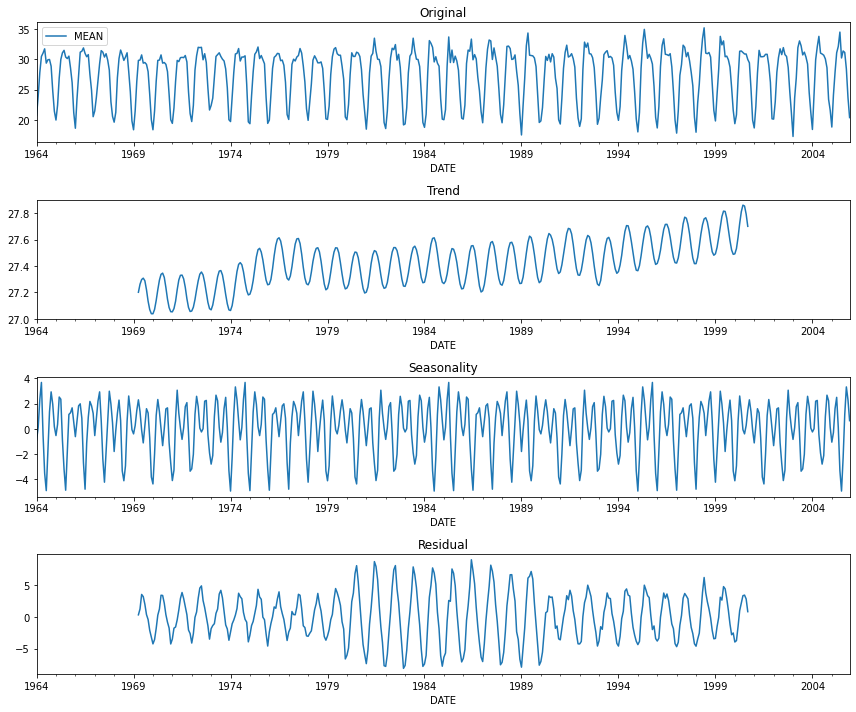

In [16]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10)) 
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [17]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

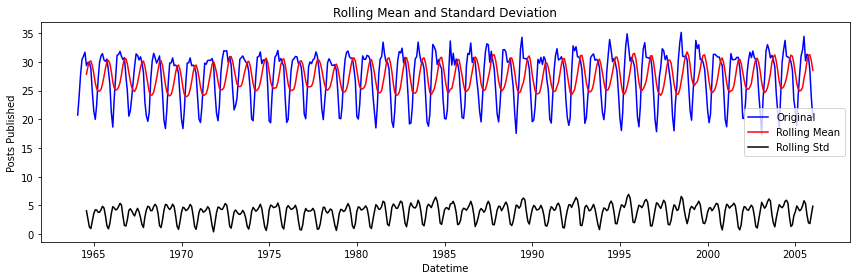

Results of Dickey-Fuller Test:
Test Statistic                  -4.310010
P-Value                          0.000427
#Lags Used                      16.000000
Number of Observations Used    487.000000
Critical Value (1%)             -3.443849
Critical Value (5%)             -2.867493
Critical Value (10%)            -2.569941
dtype: float64


In [18]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL 

In [19]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [20]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   MEAN   No. Observations:                  504
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -855.609
Date:                Mon, 07 Nov 2022   AIC                           1729.219
Time:                        09:02:01   BIC                           1767.204
Sample:                    01-31-1964   HQIC                          1744.120
                         - 12-31-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8019      0.035     22.809      0.000       0.733       0.871
ar.L2         -0.2132      0.052     -4.122      0.000      -0.315      -0.112
ar.L3         -0.4066      0.056     -7.271      0.0

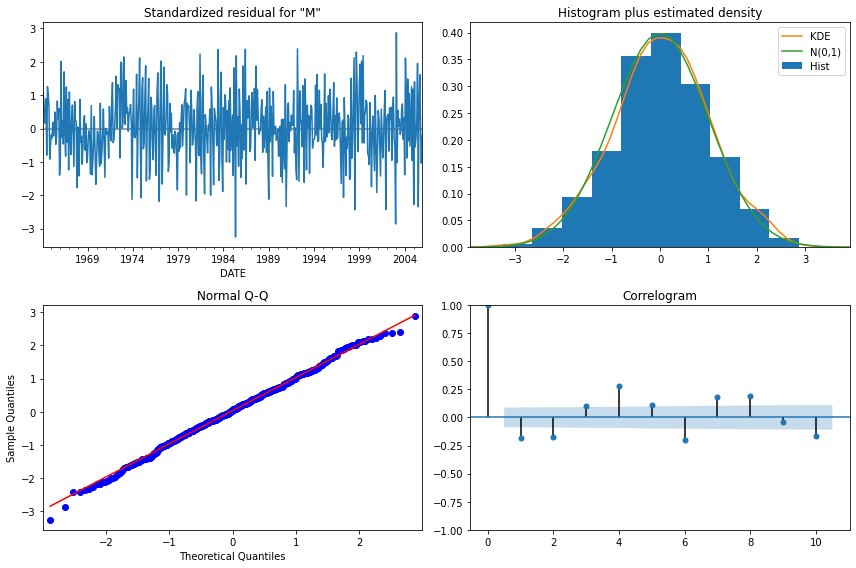

In [21]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

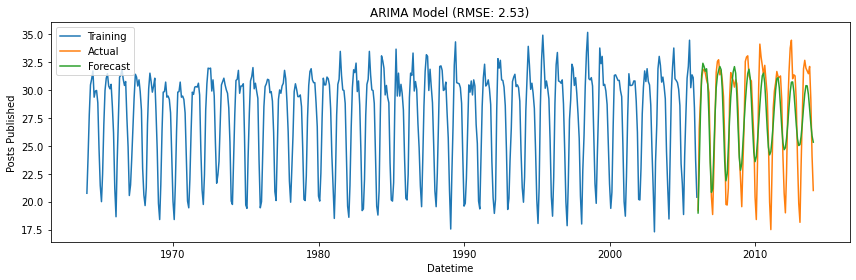

In [22]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [23]:
#Values of ARIMA prediction
print(forecast_arima)

2006-01-31    18.988615
2006-02-28    23.103295
2006-03-31    27.837027
2006-04-30    31.276256
2006-05-31    32.385722
                ...    
2013-08-31    29.584164
2013-09-30    28.320934
2013-10-31    26.966886
2013-11-30    25.887949
2013-12-31    25.322356
Freq: M, Name: predicted_mean, Length: 96, dtype: float64


In [24]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  2.530957210791785


---------------------

SARIMAX MODEL

In [25]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [26]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                               MEAN   No. Observations:                  504
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                -643.753
Date:                            Mon, 07 Nov 2022   AIC                           1321.506
Time:                                    09:04:12   BIC                           1392.845
Sample:                                01-31-1964   HQIC                          1349.521
                                     - 12-31-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2245      0.047      4.743      0.000       0.132       0.317
ar.L2          0.0595      0.051   

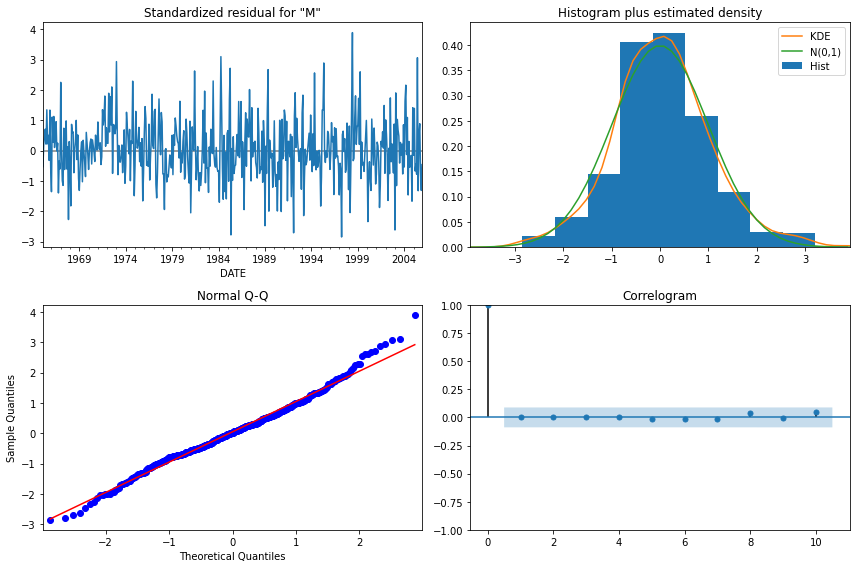

In [27]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

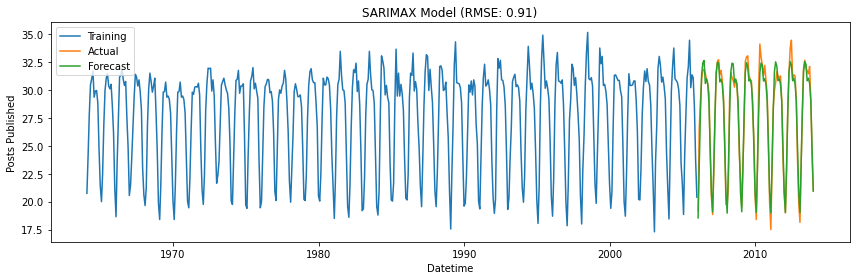

In [28]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [29]:
#Value of SARIMA prediction
print(forecast_sarimax)

2006-01-31    18.549353
2006-02-28    23.144928
2006-03-31    27.906270
2006-04-30    31.418273
2006-05-31    32.442189
                ...    
2013-08-31    31.044788
2013-09-30    30.583757
2013-10-31    28.974569
2013-11-30    24.916501
2013-12-31    20.938475
Freq: M, Name: predicted_mean, Length: 96, dtype: float64


In [30]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  0.9060316400690726


-----------------------

PROPHET

In [31]:
#Reading monthly data 
df= pd.read_csv('Rajshahi_monthly.csv')

In [32]:

#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1964-01-31,20.75
1,1964-02-29,23.95
2,1964-03-31,27.80
3,1964-04-30,30.45
4,1964-05-31,31.00


In [33]:
#prophet model Implement
prophet_model = Prophet()

In [34]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxbbha0w3/w4r7inkm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxbbha0w3/vwl_xkls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32996', 'data', 'file=/tmp/tmpxbbha0w3/w4r7inkm.json', 'init=/tmp/tmpxbbha0w3/vwl_xkls.json', 'output', 'file=/tmp/tmpxbbha0w3/prophet_model7k1k1_9u/prophet_model-20221107090414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:04:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:04:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [35]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 11, freq='M')
print(prophet_forecast_date)

            ds
0   1964-01-31
1   1964-02-29
2   1964-03-31
3   1964-04-30
4   1964-05-31
..         ...
727 2024-08-31
728 2024-09-30
729 2024-10-31
730 2024-11-30
731 2024-12-31

[732 rows x 1 columns]


In [36]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1964-01-31,27.160440,17.824764,20.139792,27.160440,27.160440,-8.167503,-8.167503,-8.167503,-8.167503,-8.167503,-8.167503,0.0,0.0,0.0,18.992937
1,1964-02-29,27.160805,20.915063,23.260610,27.160805,27.160805,-5.030316,-5.030316,-5.030316,-5.030316,-5.030316,-5.030316,0.0,0.0,0.0,22.130489
2,1964-03-31,27.161195,26.337831,28.737377,27.161195,27.161195,0.420035,0.420035,0.420035,0.420035,0.420035,0.420035,0.0,0.0,0.0,27.581230
3,1964-04-30,27.161573,29.882579,32.194437,27.161573,27.161573,3.866093,3.866093,3.866093,3.866093,3.866093,3.866093,0.0,0.0,0.0,31.027665
4,1964-05-31,27.161963,30.227591,32.589744,27.161963,27.161963,4.263025,4.263025,4.263025,4.263025,4.263025,4.263025,0.0,0.0,0.0,31.424988


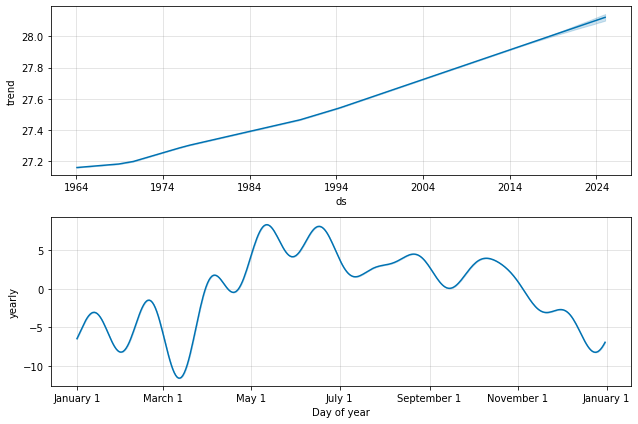

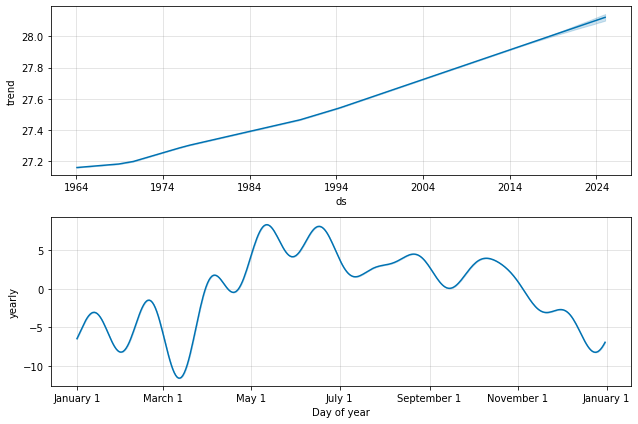

In [37]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [38]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe 
fd=forecast_prophet_data.set_index('ds')
print(fd)

                 yhat
ds                   
1964-01-31  18.992937
1964-02-29  22.130489
1964-03-31  27.581230
1964-04-30  31.027665
1964-05-31  31.424988
...               ...
2024-08-31  31.169000
2024-09-30  31.058453
2024-10-31  29.250507
2024-11-30  25.443491
2024-12-31  21.283585

[732 rows x 1 columns]


In [39]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1964-01-31    18.992937
1964-02-29    22.130489
1964-03-31    27.581230
1964-04-30    31.027665
1964-05-31    31.424988
                ...    
2024-08-31    31.169000
2024-09-30    31.058453
2024-10-31    29.250507
2024-11-30    25.443491
2024-12-31    21.283585
Name: yhat, Length: 732, dtype: float64


In [40]:
print(valid)

             MEAN
DATE             
2006-01-31  19.20
2006-02-28  26.50
2006-03-31  29.05
2006-04-30  31.00
2006-05-31  31.70
...           ...
2013-08-31  31.45
2013-09-30  32.10
2013-10-31  29.10
2013-11-30  24.10
2013-12-31  21.00

[96 rows x 1 columns]


In [41]:
forecast_prophet_valid=full_forecast_prophet['2006-01-31':'2013-12-31']

In [42]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  0.9171647822806788


-----------------

MODEL Comparison
----------

Testing

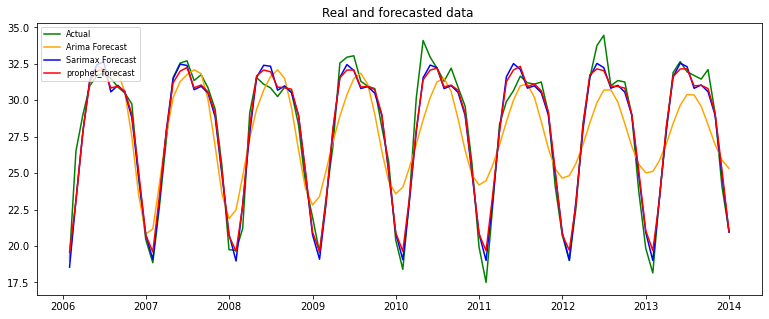

In [43]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

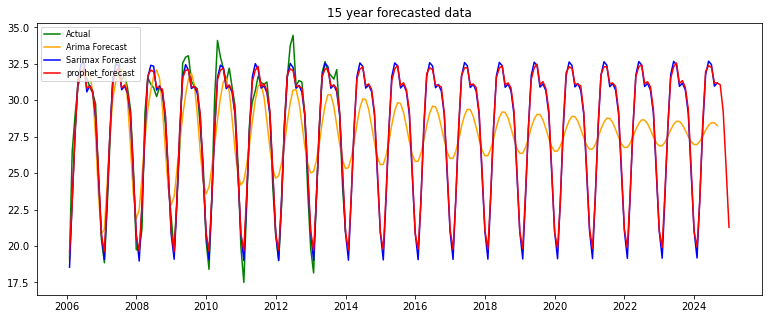

In [44]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+128)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+128)
forecast_10_prophet=full_forecast_prophet['2006-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

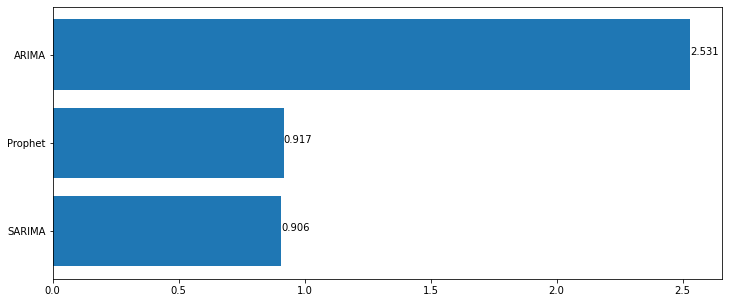

In [45]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)
 
for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))
 
plt.show()

In [46]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--
Enter a date in yyyy-mm-dd format :2021-01-31

Great! Now choose the model result you want to see for 2021-01-31
 1.Arima 
 2.Sarimax
 3.Prophet
 2
Choosen Model is Sarimax
In 2021-01-31 rainfall value for Sarimax model:  19.136266098329635


In [47]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Rajshahi-monthly_merged.csv")